# Run SDM for Snowdon Beetle (*Chrysolina cerealis*)

Now you have prepared the data layers, the next stage is to run the Species Distribution Modelling (SDM). 

## Import Modules

In [52]:
import glob
import os

import rsgislib
import rsgislib.imageutils
import rsgislib.tools.filetools
import rsgislib.tools.utils
import rsgislib.vectorutils
import species_distribution

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import rsgislib.tools.mapping

## Create Output Data Directories

In [2]:
out_dir = "sdm_LogReg_outs"
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

tmp_dir = "tmp_dir"
if not os.path.exists(tmp_dir):
    os.mkdir(tmp_dir)

## Set all GTIFF Image Outputs to be Compressed

In [3]:
rsgislib.imageutils.set_env_vars_lzw_gtiff_outs()

## Define Input Data Files

In [9]:
# Sighting (Presence) Data
presence_sightings_vec_file = "Chrysolina_cerealis_osgb.geojson"
presence_sightings_vec_lyr = "Chrysolina_cerealis_osgb"

# ROI Mask Image
study_site_msk_img = "Study_Area.tif"

# Environmental Images:
elevation_img = "../data/sdm/environmental_data/elevation.tif"
winter_temp_img = "../data/sdm/environmental_data/Mean_Winter_Temp.tif"
dist_phase1_imgs = glob.glob("phase1_dist_imgs/*.tif")

## 1. Create Pseudo Absences

In [17]:
pseudo_absences_vec_lyr = "pseudo_absences"
pseudo_absences_vec_file = os.path.join(out_dir, f"{pseudo_absences_vec_lyr}.geojson")

species_distribution.gen_pseudo_absences_smpls(
    in_msk_img=study_site_msk_img,
    img_msk_val=1,
    out_vec_file=pseudo_absences_vec_file,
    out_vec_lyr=pseudo_absences_vec_lyr,
    n_smpls=1000,
    xtra_n_smpls=5000,
    presence_smpls_vec_file=presence_sightings_vec_file,
    presence_smpls_vec_lyr=presence_sightings_vec_lyr,
    presence_smpls_dist_thres=250,
    out_format="GeoJSON",
    rnd_seed=None,
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:00<00:00, 66570.44it/s]


1
1


## 2. Create the dictionary of Environmental Variables

In [22]:
env_vars = dict()
env_vars["elevation"] = species_distribution.EnvVarInfo(
    name="elevation",
    file=elevation_img,
    band=1,
    data_type=rsgislib.VAR_TYPE_CONTINUOUS,
    min_vld_val=0,
    max_vld_val=2500,
)

env_vars["winter temperature"] = species_distribution.EnvVarInfo(
    name="winter temperature",
    file=winter_temp_img,
    band=1,
    data_type=rsgislib.VAR_TYPE_CONTINUOUS,
    min_vld_val=0,
    max_vld_val=10,
)

# Loop through the distance image and create the EnvVarInfo
# objects for each distance image.
for dist_img in dist_phase1_imgs:
    print(dist_img)
    dist_basename = rsgislib.tools.filetools.get_file_basename(dist_img)
    dist_name = dist_basename.replace("_", " ").lower()
    print(f"\t{dist_name}")

    env_vars[dist_name] = species_distribution.EnvVarInfo(
        name=dist_name,
        file=dist_img,
        band=1,
        data_type=rsgislib.VAR_TYPE_CONTINUOUS,
        min_vld_val=0,
        max_vld_val=20000,
    )

phase1_dist_imgs/Quarry_dist.tif
	quarry dist
phase1_dist_imgs/Lichenbryophyte_heath_dist.tif
	lichenbryophyte heath dist
phase1_dist_imgs/Fen_dist.tif
	fen dist
phase1_dist_imgs/mosaic_dist.tif
	mosaic dist
phase1_dist_imgs/Blanket_bog_dist.tif
	blanket bog dist
phase1_dist_imgs/Wet_heath_dist.tif
	wet heath dist
phase1_dist_imgs/Planted_coniferous_woodland_dist.tif
	planted coniferous woodland dist
phase1_dist_imgs/Natural_rock_exposure_dist.tif
	natural rock exposure dist
phase1_dist_imgs/Planted_broadleaved_woodland_dist.tif
	planted broadleaved woodland dist
phase1_dist_imgs/Acidneutral_scree_dist.tif
	acidneutral scree dist
phase1_dist_imgs/Improved_grassland_dist.tif
	improved grassland dist
phase1_dist_imgs/Flush_and_spring_dist.tif
	flush and spring dist
phase1_dist_imgs/Ephemeralshort_perennial_dist.tif
	ephemeralshort perennial dist
phase1_dist_imgs/Unimproved_calcareous_grassland_dist.tif
	unimproved calcareous grassland dist
phase1_dist_imgs/Spoil_dist.tif
	spoil dist
phas

In [23]:
analysis_vars = list()
for var in env_vars:
    analysis_vars.append(env_vars[var].name)

analysis_vars

['elevation',
 'winter temperature',
 'quarry dist',
 'lichenbryophyte heath dist',
 'fen dist',
 'mosaic dist',
 'blanket bog dist',
 'wet heath dist',
 'planted coniferous woodland dist',
 'natural rock exposure dist',
 'planted broadleaved woodland dist',
 'acidneutral scree dist',
 'improved grassland dist',
 'flush and spring dist',
 'ephemeralshort perennial dist',
 'unimproved calcareous grassland dist',
 'spoil dist',
 'upland species rich ledges dist',
 'basin mire dist',
 'bare ground dist',
 'semi natural broadleaved woodland dist',
 'marshy grassland juncus dominated dist',
 'swamp dist',
 'basic dry heathcalcareous grassland mosaic dist',
 'semi improved neutral grassland dist',
 'semi improved acid grassland dist',
 'track not comprehensively digitised dist',
 'scree dist',
 'wet heathacid grassland mosaic dist',
 'dry modified bog dist',
 'non ruderal herb and fern dist',
 'marshy grassland molinia dominated dist',
 'marshy grassland dist',
 'other rock exposure dist',
 

## 3. Extract Image Data Values for Sighting Data

In [24]:
presence_env_var_vec_lyr = "Chrysolina_cerealis_osgb_env_vars"
presence_env_var_vec_file = os.path.join(out_dir, f"{presence_env_var_vec_lyr}.gpkg")

species_distribution.extract_env_var_data(
    env_vars=env_vars,
    smpls_vec_file=presence_sightings_vec_file,
    smpls_vec_lyr=presence_sightings_vec_lyr,
    out_vec_file=presence_env_var_vec_file,
    out_vec_lyr=presence_env_var_vec_lyr,
    out_format="GPKG",
    out_no_data_val=-9999,
    replace=True,
)

Deleting: sdm_LogReg_outs/Chrysolina_cerealis_osgb_env_vars.gpkg
Processing 'elevation':


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 21479.63it/s]


Processing 'winter temperature':


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 26940.26it/s]


Processing 'quarry dist':


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 24606.69it/s]


Processing 'lichenbryophyte heath dist':


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 25195.47it/s]


Processing 'fen dist':


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 25630.18it/s]


Processing 'mosaic dist':


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 29943.14it/s]


Processing 'blanket bog dist':


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 26368.12it/s]


Processing 'wet heath dist':


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 25363.19it/s]


Processing 'planted coniferous woodland dist':


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 26615.59it/s]


Processing 'natural rock exposure dist':


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 27849.69it/s]


Processing 'planted broadleaved woodland dist':


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 29919.80it/s]


Processing 'acidneutral scree dist':


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 26880.77it/s]


Processing 'improved grassland dist':


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 28020.11it/s]


Processing 'flush and spring dist':


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 31306.67it/s]


Processing 'ephemeralshort perennial dist':


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 30490.05it/s]


Processing 'unimproved calcareous grassland dist':


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 29498.95it/s]


Processing 'spoil dist':


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 30806.21it/s]


Processing 'upland species rich ledges dist':


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 28884.39it/s]


Processing 'basin mire dist':


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 29132.21it/s]


Processing 'bare ground dist':


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 32205.59it/s]


Processing 'semi natural broadleaved woodland dist':


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 27591.05it/s]


Processing 'marshy grassland juncus dominated dist':


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 29260.30it/s]


Processing 'swamp dist':


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 31514.22it/s]


Processing 'basic dry heathcalcareous grassland mosaic dist':


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 30013.36it/s]


Processing 'semi improved neutral grassland dist':


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 31111.52it/s]


Processing 'semi improved acid grassland dist':


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 27913.55it/s]


Processing 'track not comprehensively digitised dist':


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 29462.38it/s]


Processing 'scree dist':


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 27502.88it/s]


Processing 'wet heathacid grassland mosaic dist':


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 27557.54it/s]


Processing 'dry modified bog dist':


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 28931.26it/s]


Processing 'non ruderal herb and fern dist':


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 29907.25it/s]


Processing 'marshy grassland molinia dominated dist':


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 29617.98it/s]


Processing 'marshy grassland dist':


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 27947.94it/s]


Processing 'other rock exposure dist':


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 28757.90it/s]


Processing 'dry acid heath dist':


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 30749.27it/s]


Processing 'buildings dist':


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 29521.63it/s]


Processing 'dense scrub dist':


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 26973.74it/s]


Processing 'standing water dist':


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 29030.55it/s]


Processing 'acidneutral rock dist':


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 29778.78it/s]


Processing 'unimproved acid grassland dist':


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 36581.81it/s]


Processing 'running water dist':


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 28312.56it/s]


Processing 'gardens dist':


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 31127.05it/s]


Processing 'acidneutral flush dist':


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 27919.80it/s]


Processing 'brophyte dominated spring dist':


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 28124.31it/s]


Processing 'bare peat dist':


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 31640.07it/s]


Processing 'amenity grassland dist':


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 29734.43it/s]


Processing 'bracken dist':


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 28320.60it/s]


Processing 'wet modified bog dist':


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 30412.03it/s]


In [25]:
absences_env_var_vec_lyr = "pseudo_absences_env_var"
absences_env_var_vec_file = os.path.join(out_dir, f"{absences_env_var_vec_lyr}.gpkg")

species_distribution.extract_env_var_data(
    env_vars=env_vars,
    smpls_vec_file=pseudo_absences_vec_file,
    smpls_vec_lyr=pseudo_absences_vec_lyr,
    out_vec_file=absences_env_var_vec_file,
    out_vec_lyr=absences_env_var_vec_lyr,
    out_format="GPKG",
    out_no_data_val=-9999,
    replace=True,
)

Deleting: sdm_LogReg_outs/pseudo_absences_env_var.gpkg
Processing 'elevation':


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 40489.08it/s]


Processing 'winter temperature':


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 48918.87it/s]


Processing 'quarry dist':


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 50779.11it/s]


Processing 'lichenbryophyte heath dist':


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 49947.65it/s]


Processing 'fen dist':


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 52046.26it/s]


Processing 'mosaic dist':


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 51456.28it/s]


Processing 'blanket bog dist':


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 45994.21it/s]


Processing 'wet heath dist':


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 50255.86it/s]


Processing 'planted coniferous woodland dist':


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 50330.04it/s]


Processing 'natural rock exposure dist':


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 51273.86it/s]


Processing 'planted broadleaved woodland dist':


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 50443.23it/s]


Processing 'acidneutral scree dist':


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 46229.94it/s]


Processing 'improved grassland dist':


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 49986.94it/s]


Processing 'flush and spring dist':


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 51856.43it/s]


Processing 'ephemeralshort perennial dist':


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 53186.04it/s]


Processing 'unimproved calcareous grassland dist':


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 46633.43it/s]


Processing 'spoil dist':


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 49883.49it/s]


Processing 'upland species rich ledges dist':


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 48971.42it/s]


Processing 'basin mire dist':


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 47623.58it/s]


Processing 'bare ground dist':


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 50266.10it/s]


Processing 'semi natural broadleaved woodland dist':


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 49507.84it/s]


Processing 'marshy grassland juncus dominated dist':


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 48320.92it/s]


Processing 'swamp dist':


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 49280.40it/s]


Processing 'basic dry heathcalcareous grassland mosaic dist':


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 50234.19it/s]


Processing 'semi improved neutral grassland dist':


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 50828.34it/s]


Processing 'semi improved acid grassland dist':


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 49384.84it/s]


Processing 'track not comprehensively digitised dist':


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 50258.87it/s]


Processing 'scree dist':


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 51002.02it/s]


Processing 'wet heathacid grassland mosaic dist':


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 51044.23it/s]


Processing 'dry modified bog dist':


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 51891.08it/s]


Processing 'non ruderal herb and fern dist':


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 53459.23it/s]


Processing 'marshy grassland molinia dominated dist':


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 52034.64it/s]


Processing 'marshy grassland dist':


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 51921.27it/s]


Processing 'other rock exposure dist':


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 52306.53it/s]


Processing 'dry acid heath dist':


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 52941.00it/s]


Processing 'buildings dist':


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 52496.39it/s]


Processing 'dense scrub dist':


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 52899.61it/s]


Processing 'standing water dist':


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 50975.98it/s]


Processing 'acidneutral rock dist':


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 53774.51it/s]


Processing 'unimproved acid grassland dist':


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 56072.83it/s]


Processing 'running water dist':


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 51440.50it/s]


Processing 'gardens dist':


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 54513.96it/s]


Processing 'acidneutral flush dist':


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 51725.34it/s]


Processing 'brophyte dominated spring dist':


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 52957.72it/s]


Processing 'bare peat dist':


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 54039.86it/s]


Processing 'amenity grassland dist':


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 53544.53it/s]


Processing 'bracken dist':


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 51722.78it/s]


Processing 'wet modified bog dist':


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 52974.44it/s]


In [26]:
# Remove any points which have invalid values from the input images

drop_atts = dict()
for var in analysis_vars:
    drop_atts[var] = -9999

presence_env_var_vld_vec_lyr = "Chrysolina_cerealis_osgb_env_vars_vld"
presence_env_var_vld_vec_file = os.path.join(
    out_dir, f"{presence_env_var_vec_lyr}.gpkg"
)

rsgislib.vectorutils.drop_rows_by_multi_attributes(
    vec_file=presence_env_var_vec_file,
    vec_lyr=presence_env_var_vec_lyr,
    drop_atts=drop_atts,
    out_vec_file=presence_env_var_vld_vec_file,
    out_vec_lyr=presence_env_var_vld_vec_lyr,
    out_format="GPKG",
)

absences_env_var_vld_vec_lyr = "pseudo_absences_env_var_vld"
absences_env_var_vld_vec_file = os.path.join(
    out_dir, f"{absences_env_var_vld_vec_lyr}.gpkg"
)

rsgislib.vectorutils.drop_rows_by_multi_attributes(
    vec_file=absences_env_var_vec_file,
    vec_lyr=absences_env_var_vec_lyr,
    drop_atts=drop_atts,
    out_vec_file=absences_env_var_vld_vec_file,
    out_vec_lyr=absences_env_var_vld_vec_lyr,
    out_format="GPKG",
)

elevation
winter temperature
quarry dist
lichenbryophyte heath dist
fen dist
mosaic dist
blanket bog dist
wet heath dist
planted coniferous woodland dist
natural rock exposure dist
planted broadleaved woodland dist
acidneutral scree dist
improved grassland dist
flush and spring dist
ephemeralshort perennial dist
unimproved calcareous grassland dist
spoil dist
upland species rich ledges dist
basin mire dist
bare ground dist
semi natural broadleaved woodland dist
marshy grassland juncus dominated dist
swamp dist
basic dry heathcalcareous grassland mosaic dist
semi improved neutral grassland dist
semi improved acid grassland dist
track not comprehensively digitised dist
scree dist
wet heathacid grassland mosaic dist
dry modified bog dist
non ruderal herb and fern dist
marshy grassland molinia dominated dist
marshy grassland dist
other rock exposure dist
dry acid heath dist
buildings dist
dense scrub dist
standing water dist
acidneutral rock dist
unimproved acid grassland dist
running wate

## 4. How Many Samples Are Left?

In [27]:
n_presence_pts = rsgislib.vectorutils.get_vec_feat_count(
    vec_file=presence_env_var_vec_file, vec_lyr=presence_env_var_vec_lyr
)
n_absence_pts = rsgislib.vectorutils.get_vec_feat_count(
    vec_file=absences_env_var_vec_file,
    vec_lyr=absences_env_var_vec_lyr,
)

print(f"There are {n_presence_pts} presences points")
print(f"There are {n_absence_pts} absence points")

There are 119 presences points
There are 999 absence points


## 5. Combine Presence and Absence Points

Optionally, while combining the presence and absence data the number of presence and absence samples can be equalised which is important for tree based models (e.g., Random Forests)

In [33]:
pres_abs_vec_lyr = "presences_absences_env_var_vld"
pres_abs_vec_file = os.path.join(out_dir, f"{pres_abs_vec_lyr}.gpkg")

ana_env_vars = species_distribution.combine_presence_absence_data(
    presence_smpls_vec_file=presence_env_var_vec_file,
    presence_smpls_vec_lyr=presence_env_var_vec_lyr,
    absence_smpls_vec_file=absences_env_var_vec_file,
    absence_smpls_vec_lyr=absences_env_var_vec_lyr,
    env_vars=env_vars,
    out_vec_file=pres_abs_vec_file,
    out_vec_lyr=pres_abs_vec_lyr,
    out_format="GPKG",
    equalise_smpls=False,
    cls_col="clsid",
    rnd_seed=None,
)

Dropping from presence: ['Scientific name', 'Common name', 'Occurrence status', 'Year', 'Latitude (WGS84)', 'Longitude (WGS84)', 'Coordinate uncertainty (m)', 'Recorder', 'Individual count', 'Institution code']
Dropping from absence: ['index_right', 'Scientific name', 'Common name', 'Occurrence status', 'Year', 'Latitude (WGS84)', 'Longitude (WGS84)', 'Coordinate uncertainty (m)', 'Recorder', 'Individual count', 'Institution code', 'presents_dist', 'dist_sel']


## 6. Create Comparison Plots


In [ ]:
species_distribution.comparison_box_plots(
    env_vars=env_vars,
    vec_file=pres_abs_vec_file,
    vec_lyr=pres_abs_vec_lyr,
    out_dir=os.path.join(out_dir, "boxplots"),
    cls_col="clsid",
    box_plots=True,
)

## 7. Calculate the Correlation Matrix

In [31]:
species_distribution.correlation_matrix(
    env_vars=env_vars,
    vec_file=pres_abs_vec_file,
    vec_lyr=pres_abs_vec_lyr,
    out_corr_file=os.path.join(out_dir, "correlation_matrix.csv"),
    out_plt_file=os.path.join(out_dir, "correlation_matrix.png"),
)

<Figure size 1500x1400 with 0 Axes>

## 8. Remove Correlated Variables 

Note. that removing highly correlated variables can improve the outputs. 

In this case, you can see that elevation and winter temperature are highly negatively correlated and therefore one should be removed. We'll remove 'elevation'.

In [32]:
analysis_vars.remove("elevation")

## 9. Standardise Environmental Variables

Some models (e.g., SVM and Logistic Regression) require that the variables are standardised to the same range. However, if you are using a model such as Random Forests you do not need to worry about this step. 

In [34]:
# Optionally: Standardise the continious data using mean and stdev from sample data
species_distribution.pop_normalise_coeffs(
    env_vars=env_vars,
    vec_file=pres_abs_vec_file,
    vec_lyr=pres_abs_vec_lyr,
)

In [37]:
pres_abs_std_vec_lyr = "presences_absences_env_var_vld_std"
pres_abs_std_vec_file = os.path.join(out_dir, f"{pres_abs_std_vec_lyr}.gpkg")

species_distribution.apply_normalise_coeffs(
    env_vars=env_vars,
    vec_file=pres_abs_vec_file,
    vec_lyr=pres_abs_vec_lyr,
    out_vec_file=pres_abs_std_vec_file,
    out_vec_lyr=pres_abs_std_vec_lyr,
    out_format="GPKG",
)

## 10. Create Training and Testing Datasets

In [38]:
pres_abs_std_train_vec_lyr = "presences_absences_env_var_vld_std_train"
pres_abs_std_train_vec_file = os.path.join(
    out_dir, f"{pres_abs_std_train_vec_lyr}.gpkg"
)

pres_abs_std_test_vec_lyr = "presences_absences_env_var_vld_std_test"
pres_abs_std_test_vec_file = os.path.join(out_dir, f"{pres_abs_std_test_vec_lyr}.gpkg")

species_distribution.create_train_test_sets(
    vec_file=pres_abs_std_vec_file,
    vec_lyr=pres_abs_std_vec_lyr,
    train_vec_file=pres_abs_std_train_vec_file,
    train_vec_lyr=pres_abs_std_train_vec_lyr,
    test_vec_file=pres_abs_std_test_vec_file,
    test_vec_lyr=pres_abs_std_test_vec_lyr,
    split_prop=0.8,
    cls_col="clsid",
    out_format="GPKG",
    rnd_seed=None,
)

## 11. Find Optimal Model Parameters (GridSearch)

In [42]:
lr = LogisticRegression(
    solver="liblinear",
    max_iter=500,
    penalty="l2",
    tol=0.0001,
    C=0.1,
    fit_intercept=True,
    intercept_scaling=1,
)

grid_space = {
    "max_iter": [100, 250, 500, 750],
    "penalty": ["l1", "l2"],
    "C": [0.1, 0.5, 1, 1.5],
    "tol": [0.001, 0.0001, 0.0005],
}
search_obj = GridSearchCV(
    lr, param_grid=grid_space, cv=5, scoring="accuracy", verbose=10
)


# Fit model - what about parameter optimisation (i.e., grid search)?
opt_skl_mdl, opt_mdl_params = species_distribution.search_mdl_params(
    search_obj=search_obj,
    train_vec_file=pres_abs_std_train_vec_file,
    train_vec_lyr=pres_abs_std_train_vec_lyr,
    analysis_vars=analysis_vars,
    cls_col="clsid",
)

mdl_params_file = os.path.join(out_dir, "lr_mdl_params.json")

rsgislib.tools.utils.write_dict_to_json(opt_mdl_params, out_file=mdl_params_file)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV 1/5; 1/96] START C=0.1, max_iter=100, penalty=l1, tol=0.001.................
[CV 1/5; 1/96] END C=0.1, max_iter=100, penalty=l1, tol=0.001;, score=0.922 total time=   0.0s
[CV 2/5; 1/96] START C=0.1, max_iter=100, penalty=l1, tol=0.001.................
[CV 2/5; 1/96] END C=0.1, max_iter=100, penalty=l1, tol=0.001;, score=0.939 total time=   0.0s
[CV 3/5; 1/96] START C=0.1, max_iter=100, penalty=l1, tol=0.001.................
[CV 3/5; 1/96] END C=0.1, max_iter=100, penalty=l1, tol=0.001;, score=0.927 total time=   0.0s
[CV 4/5; 1/96] START C=0.1, max_iter=100, penalty=l1, tol=0.001.................
[CV 4/5; 1/96] END C=0.1, max_iter=100, penalty=l1, tol=0.001;, score=0.916 total time=   0.0s
[CV 5/5; 1/96] START C=0.1, max_iter=100, penalty=l1, tol=0.001.................
[CV 5/5; 1/96] END C=0.1, max_iter=100, penalty=l1, tol=0.001;, score=0.916 total time=   0.0s
[CV 1/5; 2/96] START C=0.1, max_iter=100, penalty=l1, tol=

## 12. Train a Single Model to Explore Fit

In [43]:
mdl_params = rsgislib.tools.utils.read_json_to_dict(mdl_params_file)


skl_mdl = LogisticRegression(
    solver="liblinear", fit_intercept=True, intercept_scaling=1, **mdl_params
)
train_acc, test_acc, roc_auc = species_distribution.fit_sklearn_mdl(
    est_cls_obj=skl_mdl,
    train_vec_file=pres_abs_std_train_vec_file,
    train_vec_lyr=pres_abs_std_train_vec_lyr,
    test_vec_file=pres_abs_std_test_vec_file,
    test_vec_lyr=pres_abs_std_test_vec_lyr,
    analysis_vars=analysis_vars,
    cls_col="clsid",
    roc_curve_plot=os.path.join(out_dir, "lr_testing_roc_curve.png"),
)

print(f"Train: {train_acc}")
print(f"Test: {test_acc}")
print(f"Test AUC: {roc_auc}")

Classifier Train Score = 98.66%
Classifier Test Score = 97.32%
Train: 0.9865771812080537
Test: 0.9732142857142857
Test AUC: 0.9908333333333332


<Figure size 640x480 with 0 Axes>

## 13. Jackknife Environmental Variable Importance

In [44]:
species_distribution.sklearn_jackknife_var_importance(
    est_cls_obj=skl_mdl,
    train_vec_file=pres_abs_std_train_vec_file,
    train_vec_lyr=pres_abs_std_train_vec_lyr,
    test_vec_file=pres_abs_std_test_vec_file,
    test_vec_lyr=pres_abs_std_test_vec_lyr,
    analysis_vars=analysis_vars,
    out_var_importance_file=os.path.join(out_dir, "jackknife_var_importance.csv"),
    out_importance_auc_plot=os.path.join(
        out_dir, "jackknife_var_importance_auc_plot.png"
    ),
    out_importance_test_plot=os.path.join(
        out_dir, "jackknife_var_importance_test_plot.png"
    ),
    cls_col="clsid",
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 452.58it/s]


<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

## 14. Environmental Variable Response Curves

In [45]:
species_distribution.sklearn_mdl_variable_response_curves(
    est_cls_obj = skl_mdl,
    train_vec_file=pres_abs_std_train_vec_file,
    train_vec_lyr=pres_abs_std_train_vec_lyr,
    analysis_vars=analysis_vars,
    output_file = os.path.join(out_dir, "var_response_curve_data.csv"),
    response_plots_dir = os.path.join(out_dir, "var_response_curves"),
    n_samples = 1000,
    cls_col = "clsid", 
    normalised_data = True,
    env_vars = env_vars,  
)

winter temperature Range:	(-2.1545550931844093 - 3.503034218061206): Mean = -0.8310569485620031
quarry dist Range:	(-2.2615379714860087 - 2.0642672961269173): Mean = -1.0621712479658505
lichenbryophyte heath dist Range:	(-2.579766855427128 - 2.6837202170492): Mean = -0.42247505126390295
fen dist Range:	(-1.8493518311744603 - 2.7508573280627884): Mean = 0.3147709088859245
mosaic dist Range:	(-0.6583547264842179 - 10.759837298516647): Mean = -0.35502844426758906
blanket bog dist Range:	(-1.4889240492985765 - 2.1584836396874367): Mean = 0.5701297917310088
wet heath dist Range:	(-1.484145155229312 - 3.598260687579188): Mean = 1.2836830410371622
planted coniferous woodland dist Range:	(-1.419231779919152 - 3.0496173143411096): Mean = 1.4087476331396365
natural rock exposure dist Range:	(-2.6790593907429057 - 2.700198849247526): Mean = -0.6229402673088253
planted broadleaved woodland dist Range:	(-3.4205051571048157 - 3.170850124917415): Mean = 0.48298747934226693
acidneutral scree dist Rang

/Users/pfb/Temp/rsgislib_osian_sdm/andy_sdm_tutorial/rsgislib_tutorial/13_species_distribution_modelling/species_distribution.py:1395: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


Calculating Response Curve for 'track not comprehensively digitised dist'
Calculating Response Curve for 'scree dist'
Calculating Response Curve for 'wet heathacid grassland mosaic dist'
Calculating Response Curve for 'dry modified bog dist'
Calculating Response Curve for 'non ruderal herb and fern dist'
Calculating Response Curve for 'marshy grassland molinia dominated dist'
Calculating Response Curve for 'marshy grassland dist'
Calculating Response Curve for 'other rock exposure dist'
Calculating Response Curve for 'dry acid heath dist'
Calculating Response Curve for 'buildings dist'
Calculating Response Curve for 'dense scrub dist'
Calculating Response Curve for 'standing water dist'
Calculating Response Curve for 'acidneutral rock dist'
Calculating Response Curve for 'unimproved acid grassland dist'
Calculating Response Curve for 'running water dist'
Calculating Response Curve for 'gardens dist'
Calculating Response Curve for 'acidneutral flush dist'
Calculating Response Curve for 

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

## 15. SHAP Model Explainer

/Users/pfb/miniconda3/envs/osgeo-env-v9/lib/python3.12/site-packages/shap/explainers/_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

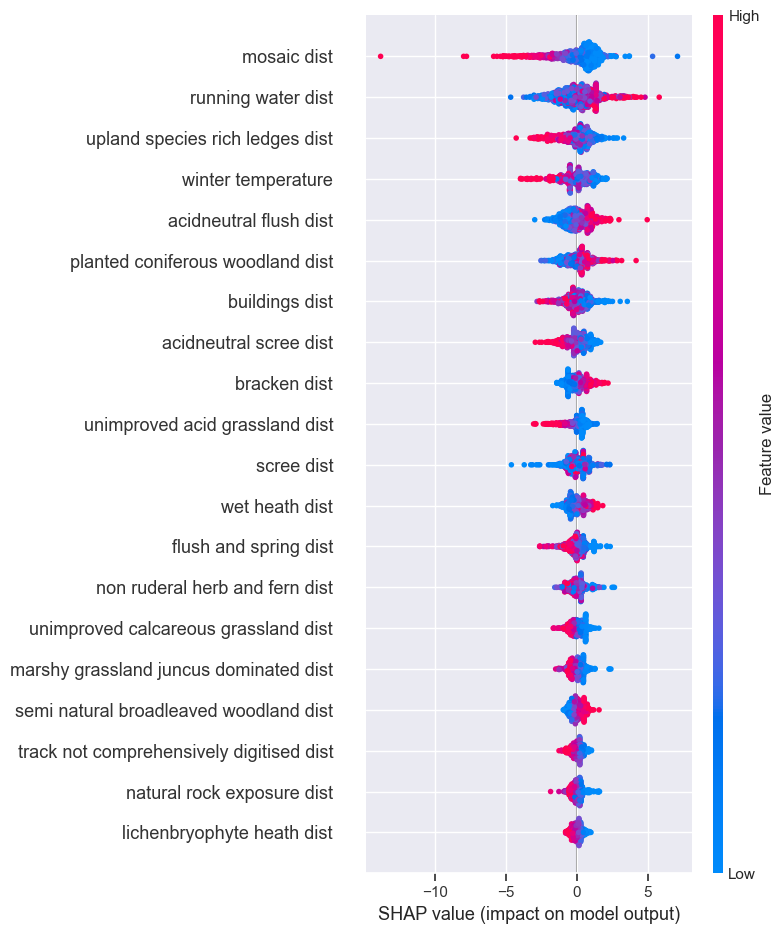

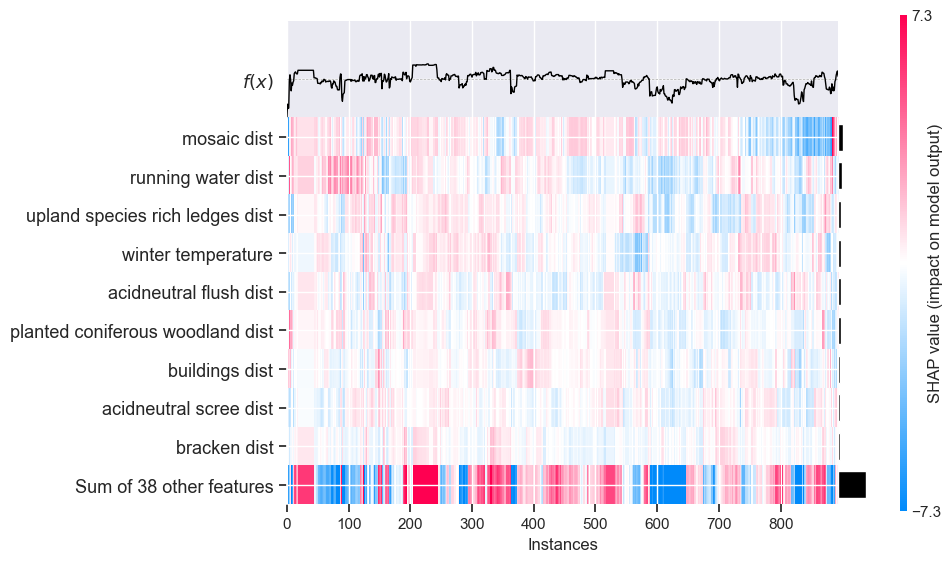

<Figure size 640x480 with 0 Axes>

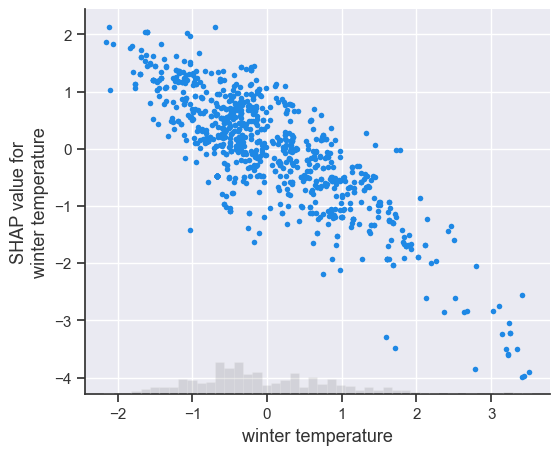

<Figure size 640x480 with 0 Axes>

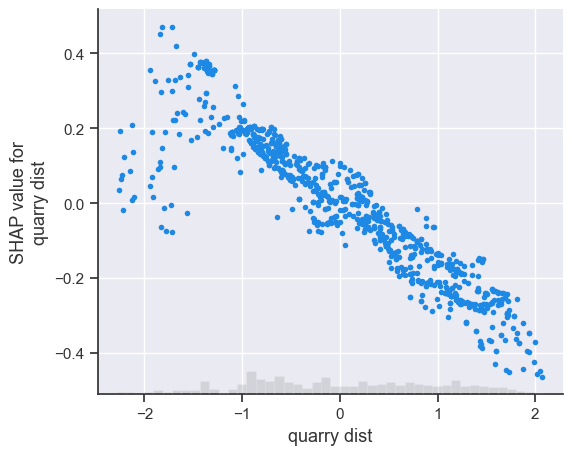

<Figure size 640x480 with 0 Axes>

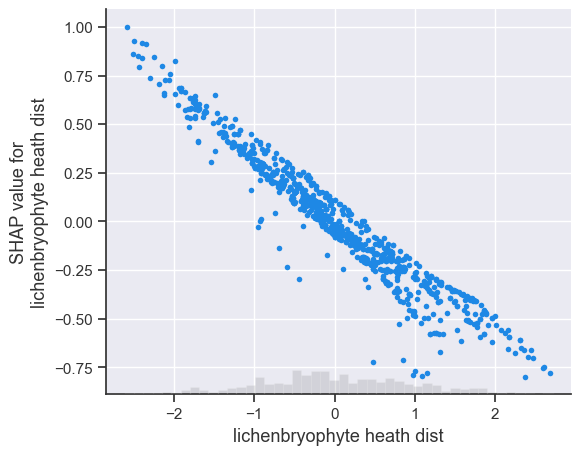

<Figure size 640x480 with 0 Axes>

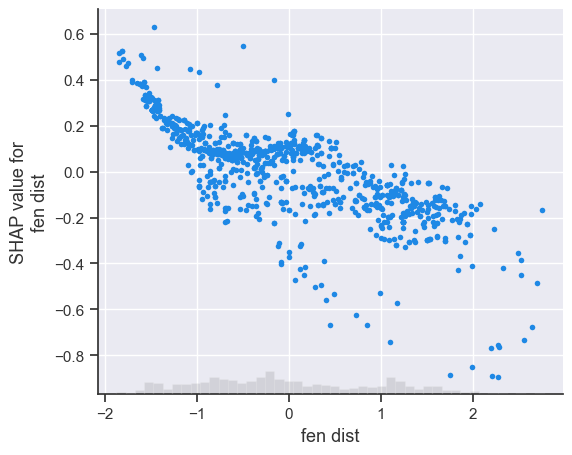

<Figure size 640x480 with 0 Axes>

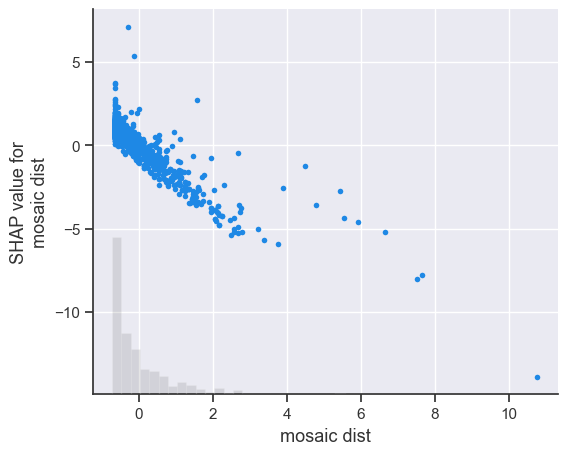

<Figure size 640x480 with 0 Axes>

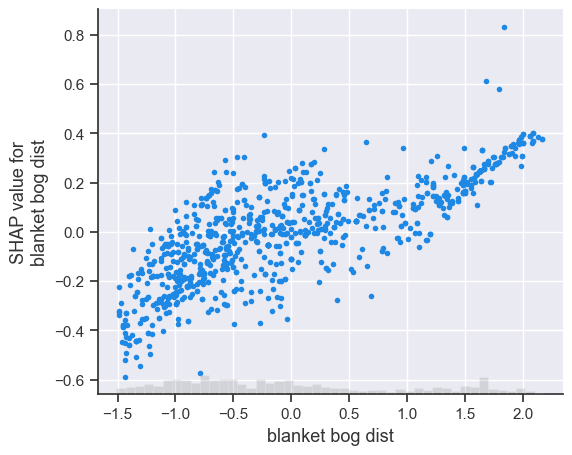

<Figure size 640x480 with 0 Axes>

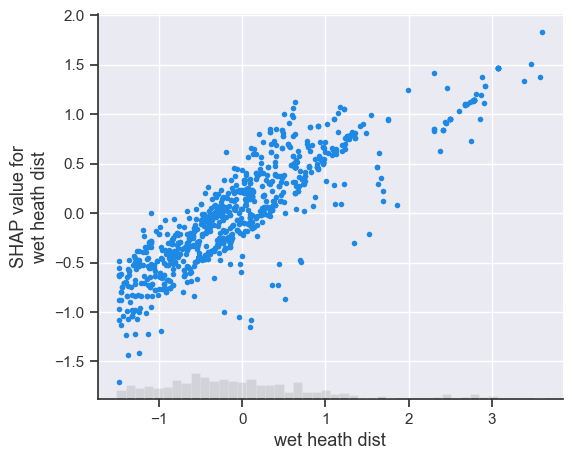

<Figure size 640x480 with 0 Axes>

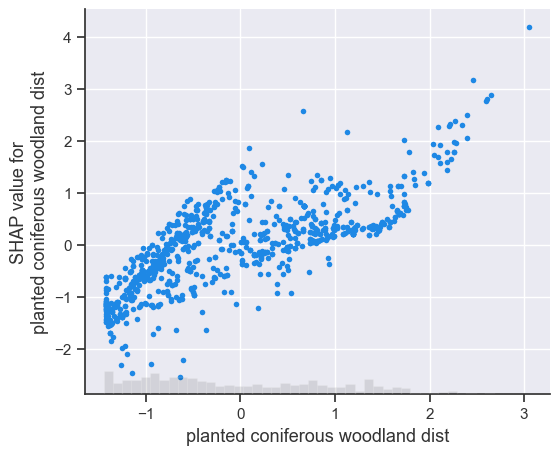

<Figure size 640x480 with 0 Axes>

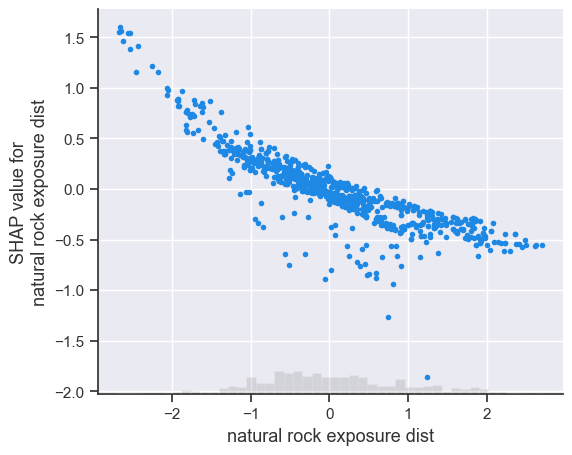

<Figure size 640x480 with 0 Axes>

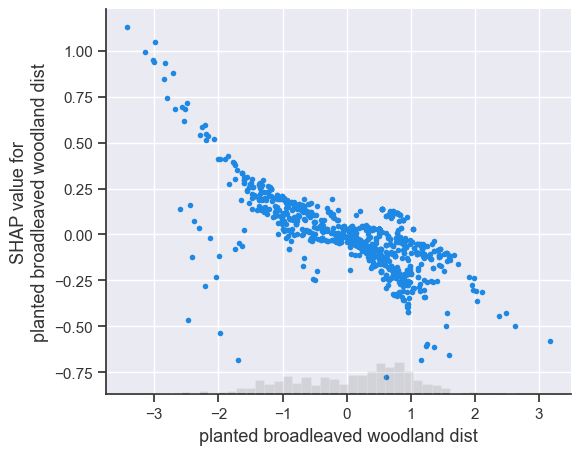

<Figure size 640x480 with 0 Axes>

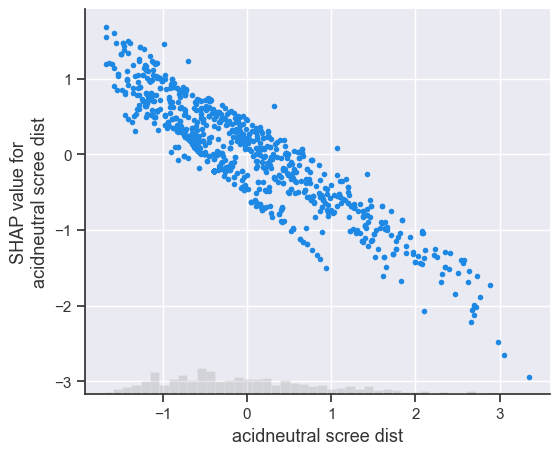

<Figure size 640x480 with 0 Axes>

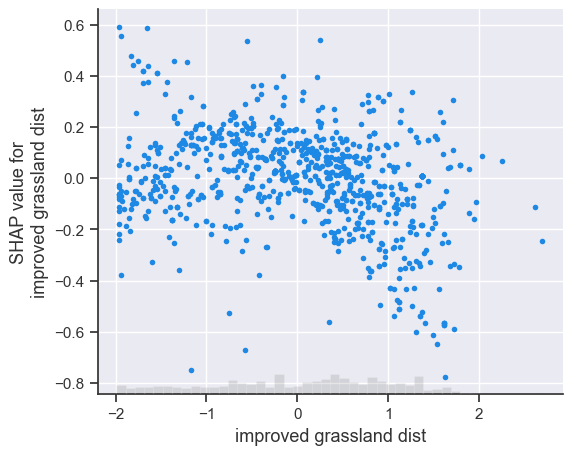

<Figure size 640x480 with 0 Axes>

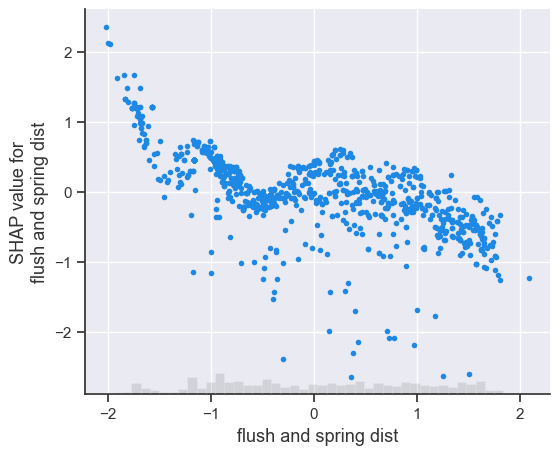

<Figure size 640x480 with 0 Axes>

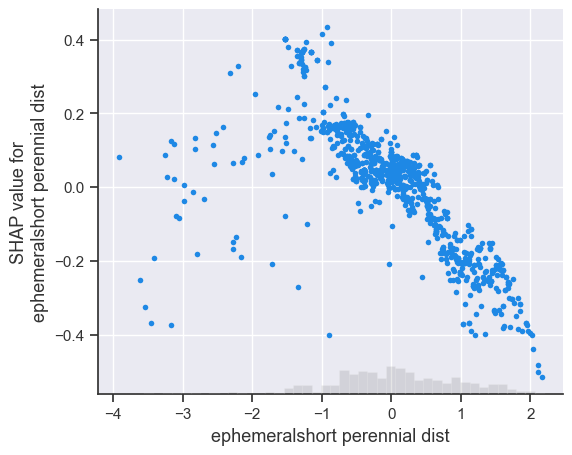

<Figure size 640x480 with 0 Axes>

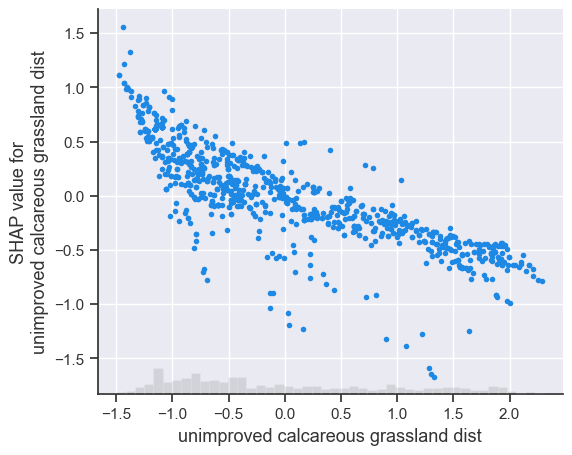

<Figure size 640x480 with 0 Axes>

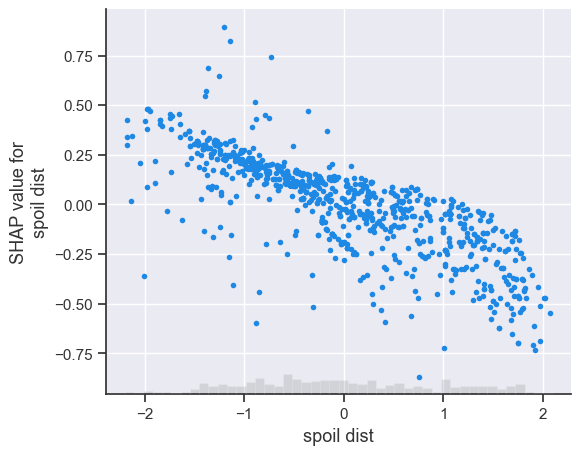

<Figure size 640x480 with 0 Axes>

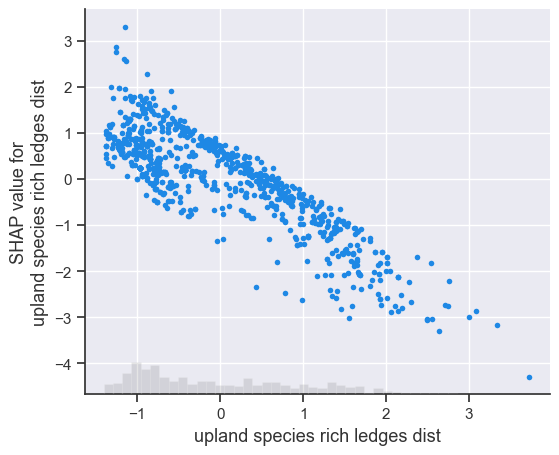

<Figure size 640x480 with 0 Axes>

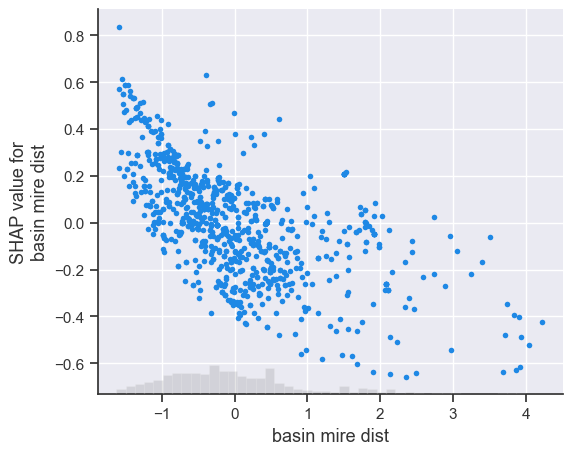

<Figure size 640x480 with 0 Axes>

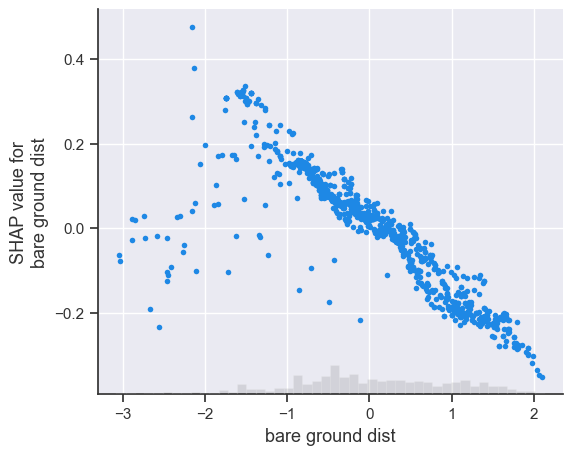

<Figure size 640x480 with 0 Axes>

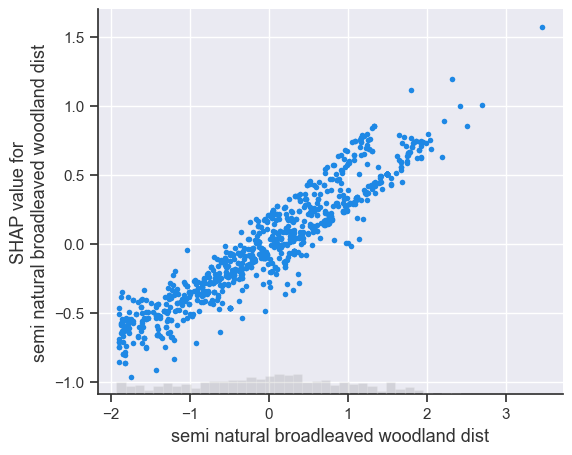

<Figure size 640x480 with 0 Axes>

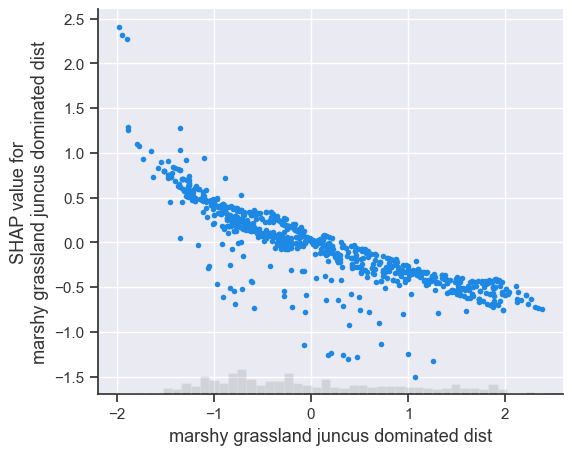

<Figure size 640x480 with 0 Axes>

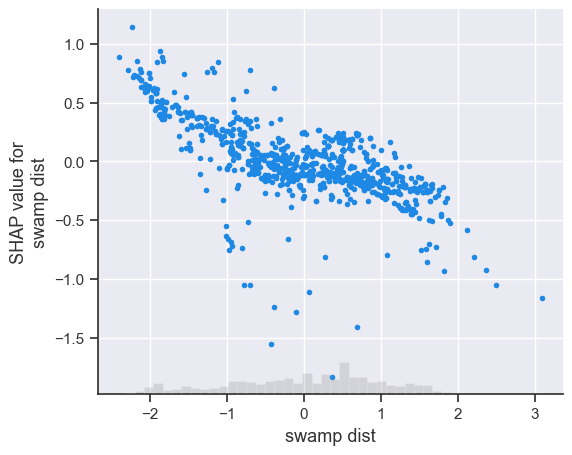

<Figure size 640x480 with 0 Axes>

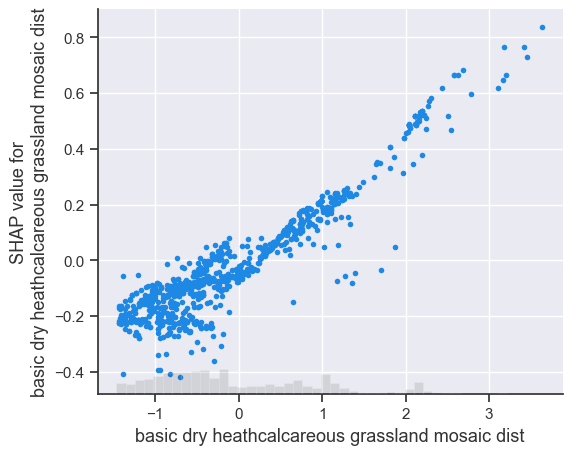

<Figure size 640x480 with 0 Axes>

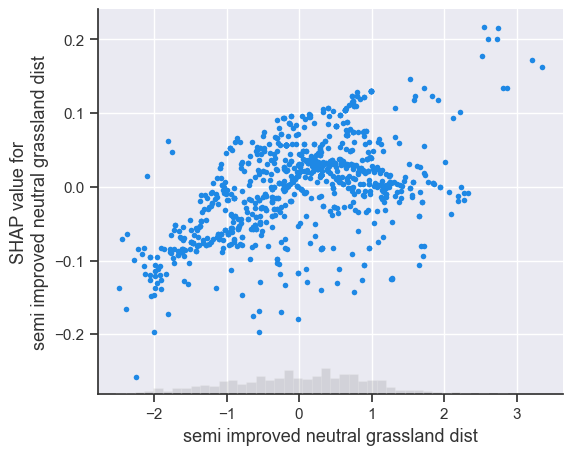

<Figure size 640x480 with 0 Axes>

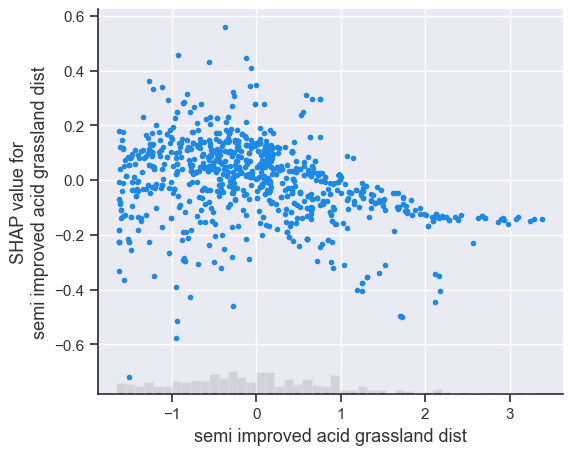

<Figure size 640x480 with 0 Axes>

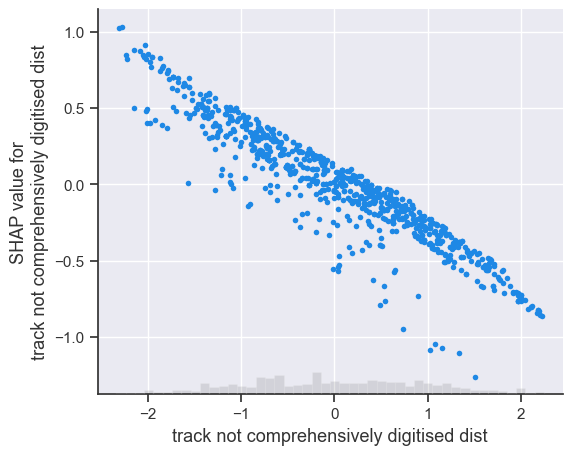

<Figure size 640x480 with 0 Axes>

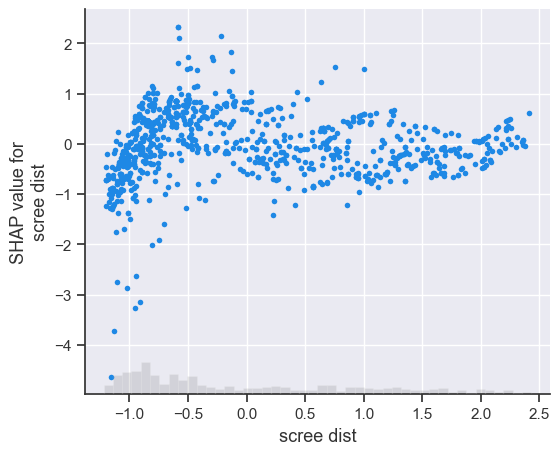

<Figure size 640x480 with 0 Axes>

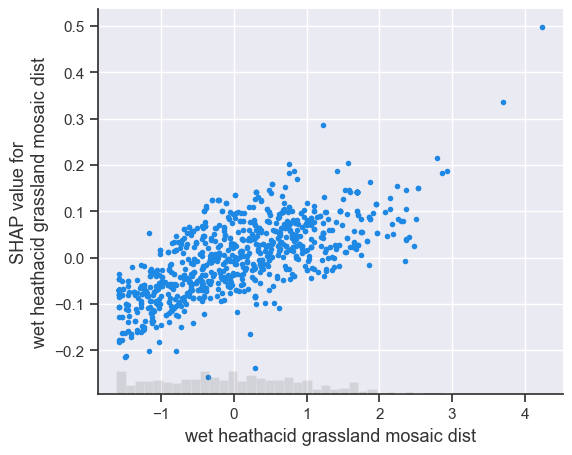

<Figure size 640x480 with 0 Axes>

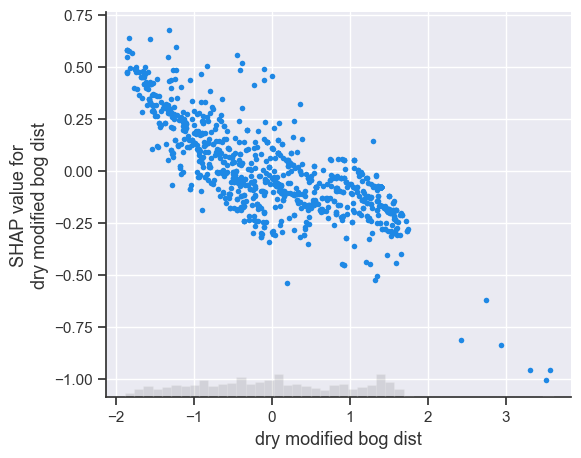

<Figure size 640x480 with 0 Axes>

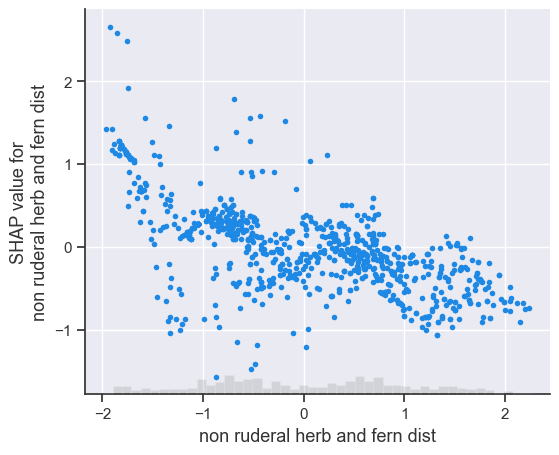

<Figure size 640x480 with 0 Axes>

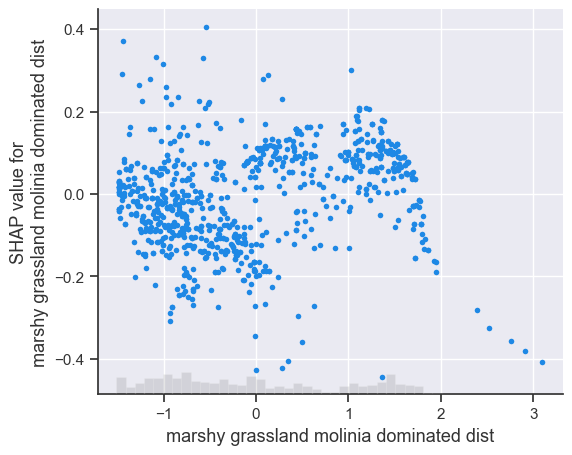

<Figure size 640x480 with 0 Axes>

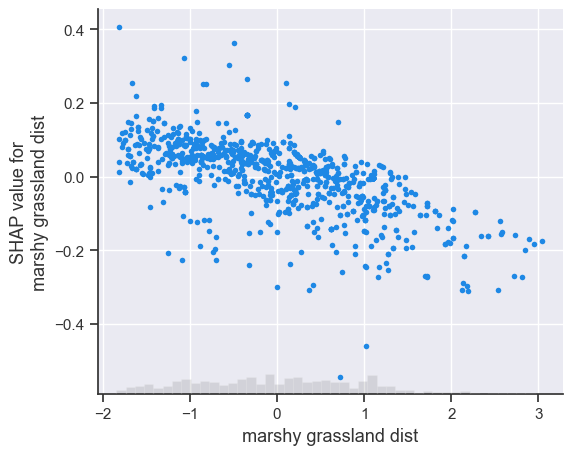

<Figure size 640x480 with 0 Axes>

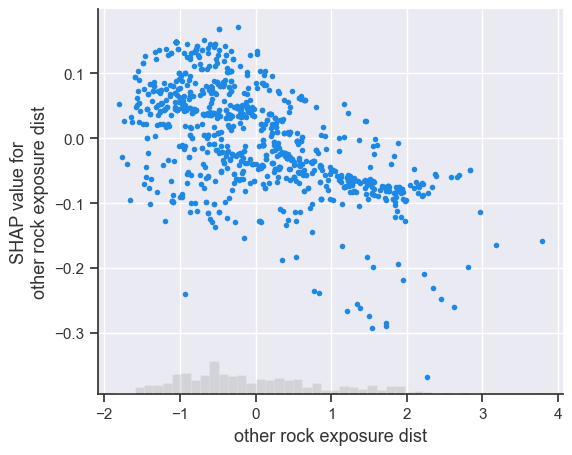

<Figure size 640x480 with 0 Axes>

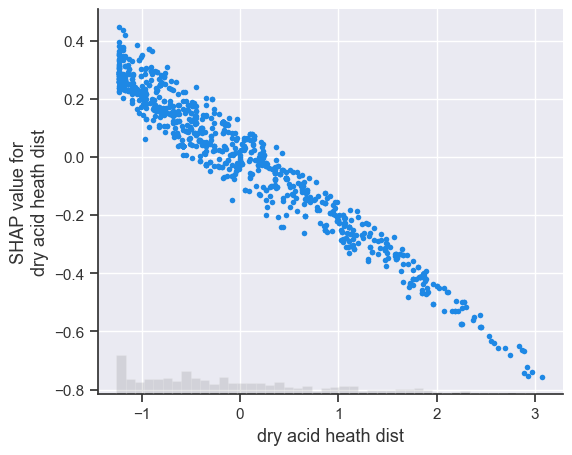

<Figure size 640x480 with 0 Axes>

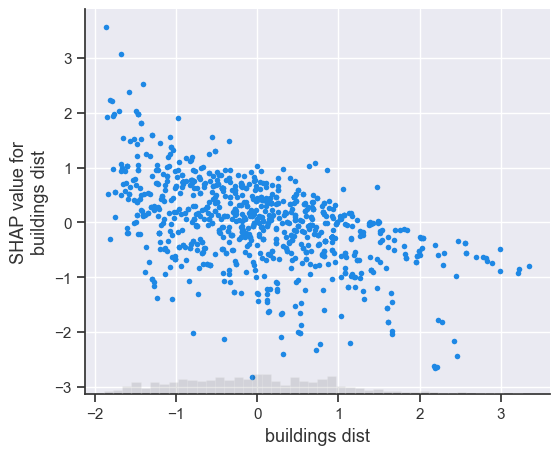

<Figure size 640x480 with 0 Axes>

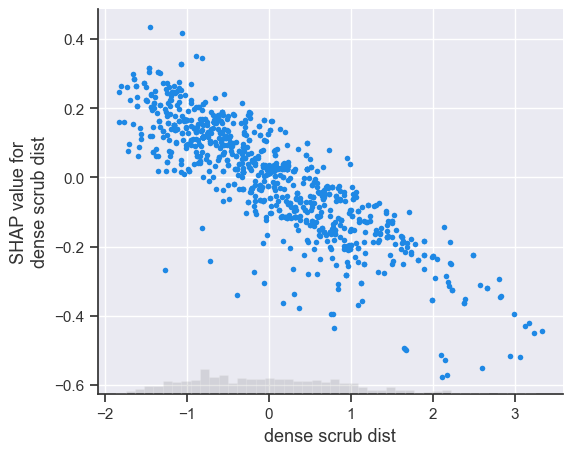

<Figure size 640x480 with 0 Axes>

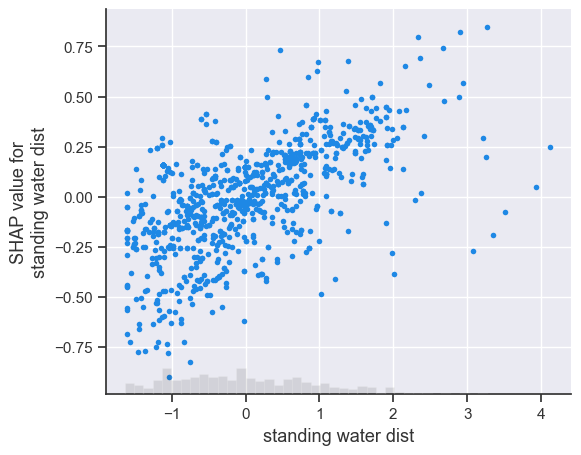

<Figure size 640x480 with 0 Axes>

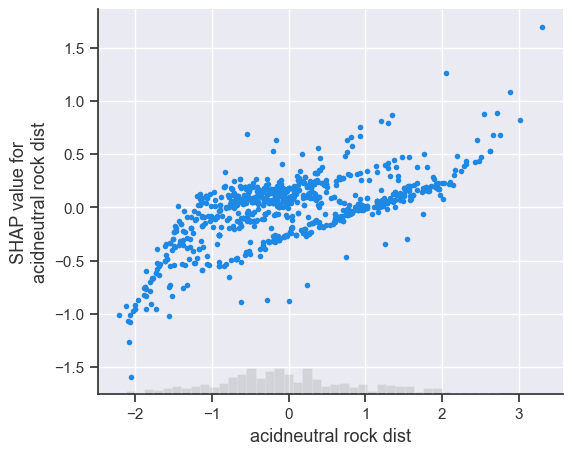

<Figure size 640x480 with 0 Axes>

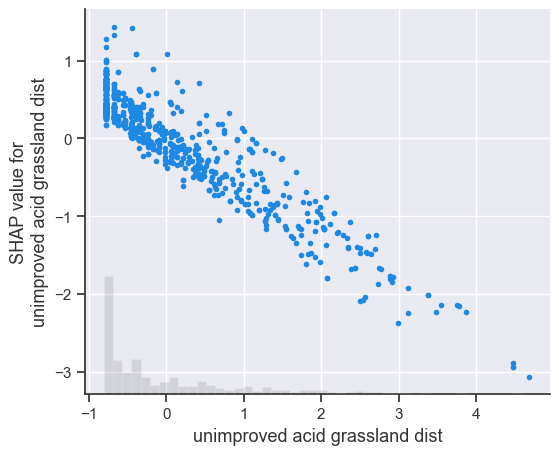

<Figure size 640x480 with 0 Axes>

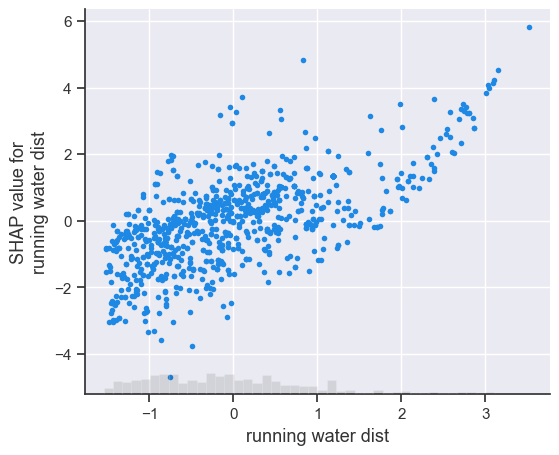

<Figure size 640x480 with 0 Axes>

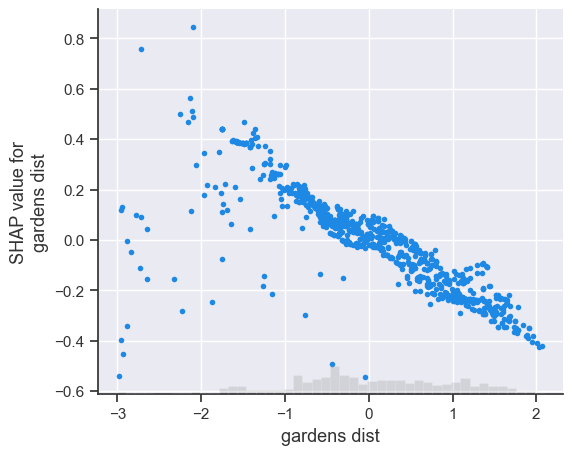

<Figure size 640x480 with 0 Axes>

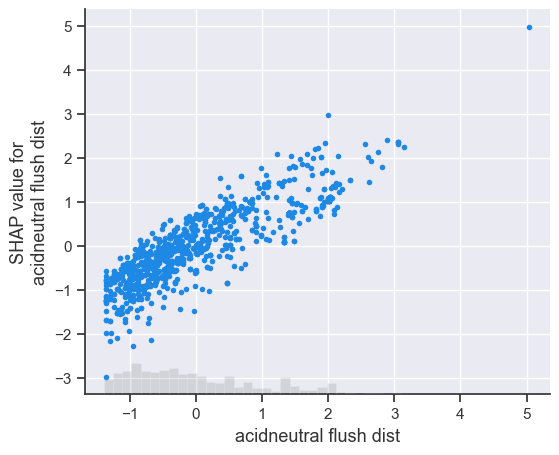

<Figure size 640x480 with 0 Axes>

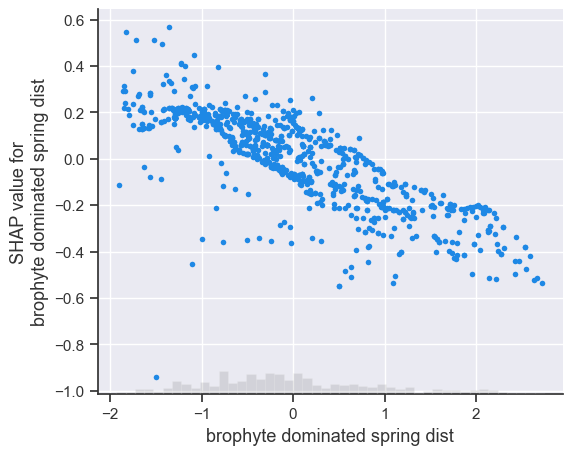

<Figure size 640x480 with 0 Axes>

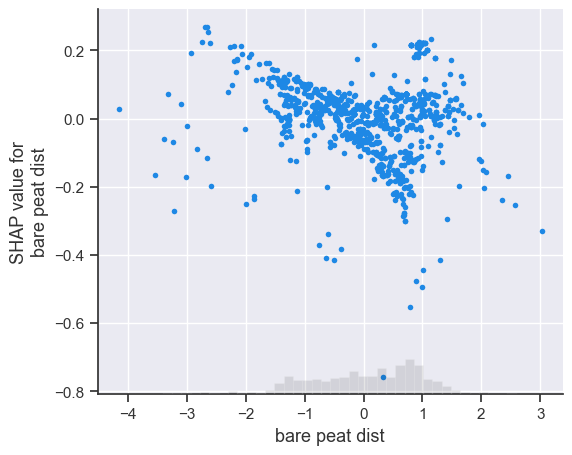

<Figure size 640x480 with 0 Axes>

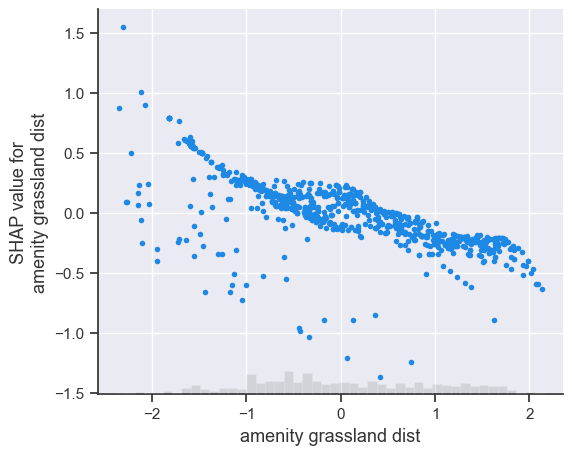

<Figure size 640x480 with 0 Axes>

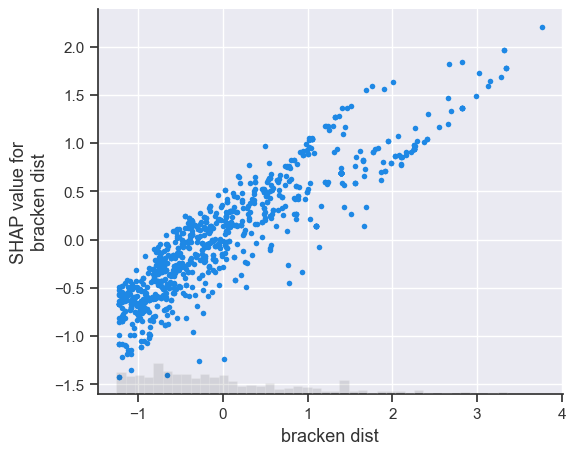

<Figure size 640x480 with 0 Axes>

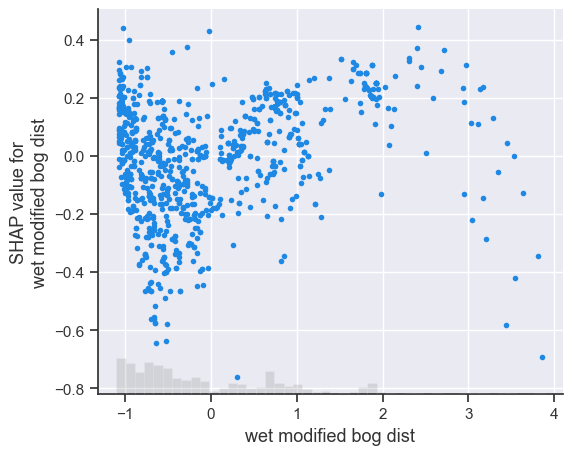

<Figure size 640x480 with 0 Axes>

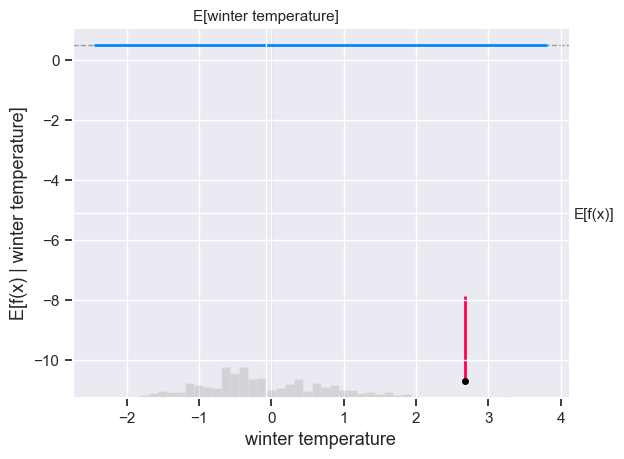

TypeError: cannot unpack non-iterable NoneType object

In [47]:
species_distribution.shap_sklearn_mdl_explainer(
    est_cls_obj=skl_mdl,
    train_vec_file=pres_abs_std_train_vec_file,
    train_vec_lyr=pres_abs_std_train_vec_lyr,
    analysis_vars=analysis_vars,
    shap_summary_plot=os.path.join(out_dir, "shap_summary_plot.png"),
    shap_heatmap_plot=os.path.join(out_dir, "shap_heatmap.png"),
    shap_scatter_plots_dir=os.path.join(out_dir, "shap_scatter_plots"),
    shap_depend_plots_dir=os.path.join(out_dir, "shap_dependence_plots"),
    subsample_n_smpls=None,
    use_tree_explainer = False,
    use_linear_explainer = True,
)

## 16. Model Sensitivity Analysis

In [49]:
species_distribution.salib_sklearn_mdl_sensitity(
    est_cls_obj = skl_mdl,
    train_vec_file=pres_abs_std_train_vec_file,
    train_vec_lyr=pres_abs_std_train_vec_lyr,
    analysis_vars=analysis_vars,
    n_samples = 1000,
    sobol_plot_file = os.path.join(out_dir, "sobol_sa_plot.png"),
    sobol_overall_file = os.path.join(out_dir, "sobol_sa_overall.csv"),
    sobol_first_file = os.path.join(out_dir, "sobol_sa_first_order.csv"),
    sobol_second_file = os.path.join(out_dir, "sobol_sa_second_order.csv"),
)

winter temperature Range:	(-2.1545550931844093 - 3.503034218061206)
quarry dist Range:	(-2.2615379714860087 - 2.0642672961269173)
lichenbryophyte heath dist Range:	(-2.579766855427128 - 2.6837202170492)
fen dist Range:	(-1.8493518311744603 - 2.7508573280627884)
mosaic dist Range:	(-0.6583547264842179 - 10.759837298516647)
blanket bog dist Range:	(-1.4889240492985765 - 2.1584836396874367)
wet heath dist Range:	(-1.484145155229312 - 3.598260687579188)
planted coniferous woodland dist Range:	(-1.419231779919152 - 3.0496173143411096)
natural rock exposure dist Range:	(-2.6790593907429057 - 2.700198849247526)
planted broadleaved woodland dist Range:	(-3.4205051571048157 - 3.170850124917415)
acidneutral scree dist Range:	(-1.671940431336383 - 3.3460043337944154)
improved grassland dist Range:	(-1.9654747954304677 - 2.689256718835557)
flush and spring dist Range:	(-2.018532032818866 - 2.0853609267816315)
ephemeralshort perennial dist Range:	(-3.9195139370482486 - 2.1594992988296897)
unimprove

/Users/pfb/miniconda3/envs/osgeo-env-v9/lib/python3.12/site-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
/Users/pfb/miniconda3/envs/osgeo-env-v9/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


<Figure size 1500x1000 with 0 Axes>

## 17. Create Ensemble of Models

Using a k-fold analysis a set of models are created with different subsets of the training data

In [50]:
skl_mdl = LogisticRegression(solver='liblinear', fit_intercept=True, intercept_scaling=1, **mdl_params)

skl_mdls = species_distribution.fit_kfold_sklearn_mdls(
    est_cls_obj=skl_mdl,
    train_vec_file=pres_abs_std_train_vec_file,
    train_vec_lyr=pres_abs_std_train_vec_lyr,
    test_vec_file=pres_abs_std_test_vec_file,
    test_vec_lyr=pres_abs_std_test_vec_lyr,
    analysis_vars=analysis_vars,
    n_kfolds=25,
    cls_col="clsid",
    rnd_seed=None,
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 84.06it/s]

ROC: 0.9447916666666667 - 0.9733333333333334 - 0.9908333333333333
Train: 0.9701492537313433 - 0.9832089552238806 - 0.9925373134328358
Test: 0.9598214285714286 - 0.96875 - 0.9866071428571429


## 18. Create an SDM Output Summarising Hard Classification

This first analysis runs the ensemble of classifiers producing a set of hard (binary) classifications which are then summarised as a proportion of classifications which are mapped as presence.

In [51]:
out_cls_img = os.path.join(out_dir, "Snowdon_Beetle_sdm_cls_prob.tif")

species_distribution.pred_ensemble_sklearn_mdls_cls(
    est_cls_objs=skl_mdls,
    in_msk_img=study_site_msk_img,
    img_msk_val=1,
    env_vars=env_vars,
    analysis_vars=analysis_vars,
    output_img=out_cls_img,
    gdalformat="GTIFF",
    tmp_dir=tmp_dir,
    normalise_data=True,
    calc_img_stats=True,
)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Opening tmp_dir/Snowdon_Beetle_sdm_cls_prob_0.tif
Opening tmp_dir/Snowdon_Beetle_sdm_cls_prob_1.tif
Opening tmp_dir/Snowdon_Beetle_sdm_cls_prob_2.tif
Opening tmp_dir/Snowdon_Beetle_sdm_cls_prob_3.tif
Opening tmp_dir/Snowdon_Beetle_sdm_cls_prob_4.tif
Opening tmp_dir/Snowdon_Beetle_sdm_cls_prob_5.tif
Opening tmp_dir/Snowdon_Beetle_sdm_cls_prob_6.tif
Opening tmp_dir/Snowdon_Beetle_sdm_cls_prob_7.tif
Opening tmp_dir/Snowdon_Beetle_sdm_cls_prob_8.tif
Opening tmp_dir/Snowdon_Beetle_sdm_cls_prob_9.tif
Opening tmp_dir/Snowdon_Beetle_sdm_cls_prob_10.tif
Opening tmp_dir/Snowdon_Beetle_sdm_cls_prob_11.tif
Opening tmp_dir/Snowdon_Beetle_sdm_cls_prob_12.tif
Opening tmp_dir/Snowdon_Beetle_sdm_cls_prob_13.tif
Opening tmp_dir/Snowdon_Beetle_sdm_cls_prob_14.tif
Opening tmp_dir/Snowdon_Beetle_sdm_cls_prob_15.tif
Opening tmp_dir/Snowdon_Beetle_sdm_cls_prob_16.tif
Opening tmp_dir/Snowdon_Beetle_sdm_cls_prob_17.tif
Opening tmp_dir/Snowdon_Beetle_sdm_cls_prob_18.tif
Opening tmp_dir/Snowdon_Beetle_sdm_cls_pr

Image Data Size: 757 x 596


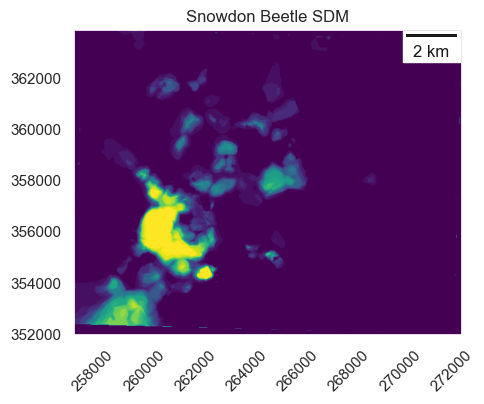

In [53]:
# Create a plot using the matplotlib library
fig, ax = plt.subplots(figsize=(5, 5))

rsgislib.tools.mapping.create_raster_cmap_img_map(
    ax,
    input_img=out_cls_img,
    img_band=1,
    title_str="Snowdon Beetle SDM",
)
ax.tick_params(axis="x", labelrotation=45)

## 19. Create an SDM Output Summarising Model Probability Outputs

This second analysis runs the ensemble of classifiers producing a probability output which are then summarised as the median probability from all the models

In [54]:
out_prob_img = os.path.join(out_dir, "Snowdon_Beetle_sdm_med_prob.tif")

species_distribution.pred_ensemble_sklearn_mdls_prob(
    est_cls_objs=skl_mdls,
    in_msk_img=study_site_msk_img,
    img_msk_val=1,
    env_vars=env_vars,
    analysis_vars=analysis_vars,
    output_img=out_prob_img,
    gdalformat="GTIFF",
    tmp_dir=tmp_dir,
    normalise_data=True,
    calc_img_stats=True,
)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Opening tmp_dir/Snowdon_Beetle_sdm_med_prob_0.tif
Opening tmp_dir/Snowdon_Beetle_sdm_med_prob_1.tif
Opening tmp_dir/Snowdon_Beetle_sdm_med_prob_2.tif
Opening tmp_dir/Snowdon_Beetle_sdm_med_prob_3.tif
Opening tmp_dir/Snowdon_Beetle_sdm_med_prob_4.tif
Opening tmp_dir/Snowdon_Beetle_sdm_med_prob_5.tif
Opening tmp_dir/Snowdon_Beetle_sdm_med_prob_6.tif
Opening tmp_dir/Snowdon_Beetle_sdm_med_prob_7.tif
Opening tmp_dir/Snowdon_Beetle_sdm_med_prob_8.tif
Opening tmp_dir/Snowdon_Beetle_sdm_med_prob_9.tif
Opening tmp_dir/Snowdon_Beetle_sdm_med_prob_10.tif
Opening tmp_dir/Snowdon_Beetle_sdm_med_prob_11.tif
Opening tmp_dir/Snowdon_Beetle_sdm_med_prob_12.tif
Opening tmp_dir/Snowdon_Beetle_sdm_med_prob_13.tif
Opening tmp_dir/Snowdon_Beetle_sdm_med_prob_14.tif
Opening tmp_dir/Snowdon_Beetle_sdm_med_prob_15.tif
Opening tmp_dir/Snowdon_Beetle_sdm_med_prob_16.tif
Opening tmp_dir/Snowdon_Beetle_sdm_med_prob_17.tif
Opening tmp_dir/Snowdon_Beetle_sdm_med_prob_18.tif
Opening tmp_dir/Snowdon_Beetle_sdm_med_pr

Image Data Size: 757 x 596


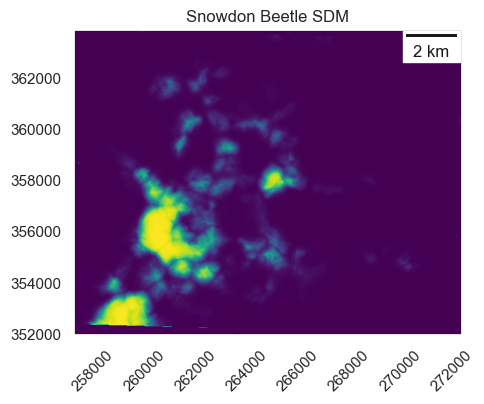

In [55]:
# Create a plot using the matplotlib library
fig, ax = plt.subplots(figsize=(5, 5))

rsgislib.tools.mapping.create_raster_cmap_img_map(
    ax,
    input_img=out_prob_img,
    img_band=1,
    title_str="Snowdon Beetle SDM",
)
ax.tick_params(axis="x", labelrotation=45)